In [2]:
!pip install tbcontrol
import control
import numpy
import matplotlib.pyplot as plt
import tbcontrol
tbcontrol.expectversion("0.1.10")
%matplotlib inline
# import pandas as pd
import scipy.optimize
from tbcontrol.responses import fopdt, sopdt
from ipywidgets import interact

def resultplot1(K, tau, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, fopdt(ts, K, tau, theta, y0), color='red')
    plt.grid(True)

def resultplot2(K, tau, zeta, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, sopdt(ts, K, tau, zeta,theta, y0), color='red')
    plt.grid(True)

# Identificación: Ajuste de la respuesta al escalón


## Respuesta al escalón

La respuesta de un sistema **LTI** $\mathcal{H}$ ante una señal escalón $\epsilon(t)$ en la entrada se conoce como [*respuesta al escalón*](https://en.wikipedia.org/wiki/Step_response) $h_\epsilon(t)$.

Se define como:

\begin{equation}
h_\epsilon(t) = \mathcal{H} \{ \epsilon(t) \}
\end{equation}

Puede entenderse la señal escalón en la entrada como el encendido/activación de un sistema en el instante $t=0$. Se relaciona con la respuesta al impulso $h(t)$ mediante:

\begin{equation}
h_\epsilon(t) = \epsilon(t) * h(t) = \int_{-\infty}^{t} h(\tau) \; d\tau
\end{equation}

Pues debe tenerse en cuenta que:

\begin{equation}
\epsilon(t) = \int_{-\infty}^{t} \delta(\tau) d\tau
\end{equation}

Esta expresión muestra que la respuesta al impulso puede encontrarse a partir de la respuesta al escalón mediante:


\begin{equation}
h(t) = \frac{d h_\epsilon(t)}{dt}
\end{equation}

Así, la respuesta de un sistema LTI $y(t) = \mathcal{H} \{ x(t) \}$  ante cualquier señal de entrada $x(t)$ puede encontrarse a partir de la respuesta al escalón como:

\begin{equation}
y(t) = x(t) * \frac{d h_\epsilon(t)}{dt} = \frac{d x(t)}{dt} * h_\epsilon(t)
\end{equation}

Observe que la señal de salida del sistema LTI está definida por :
- La covolución de la **derivada de la señal de entrada** con la **respuesta al escalón**.
- La covolución de la **señal de entrada** con la **derivada de la respuesta al escalón**.

Así, la respuesta al escalón es una alternativa apropiada a la caracterización de sistemas LTI pues el impulso de Dirac no puede obtenerse en la el mundo real.

## Función de transferencia

En el dominio del tiempo, la salida $y(t)$ de un [sistema LTI](https://es.wikipedia.org/wiki/Sistema_LTI) está determinada por la convolución entre la entrada $x(t)$ y su [respuesta al impulso](../systems_time_domain/impulse_response.ipynb) $h(t)$.

![bloque](figuras/bloque_tiempo.PNG)


\begin{equation}
y(t) = x(t) * h(t)
\end{equation}

En el dominio transformado se tiene

\begin{equation}
Y(s) = X(s) \cdot H(s)
\end{equation}

\begin{equation}
H(s) = \frac{Y(s)}{X(s)}
\end{equation}

donde:
- $X(s) = \mathcal{L} \{ x(t) \}$ es la transformada de Laplace de la señal de entrada.
- $Y(s) = \mathcal{L} \{ y(t) \}$ es la transformada de Laplace de la señal salida.
- $H(s) = \mathcal{L} \{ h(t) \}$ es la transformada de Laplace de la respuesta impulsional, también denominada [Función de transferencia](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_transferencia).


Así, un sistema LTI queda modelado mediante la respuesta impulsional bien sea en el dominio temporal o en el dominio frecuencial.


### Estrategia tentativa para obtener un modelo

Pasos para obtener experimentalmente un modelo $H(S)$ apropiado para un sistema:

- Se excita el sistema con una entrada conocida evitando comportamientos no lineales.
- Se encuentra una expresión matemática en el dominio de las frecuencias que se ajuste a la señal de salida obtenida.
- Se encuentra el cociente entre las representaciones frecuenciales de la salida y la entrada.

En sistemas de orden elevado es recomendable encontrar modelos de orden más bajo.

## Ejemplo

Suponga un sistema de orden elevado cuyo modelo conoce

\begin{equation}
G_{real}(s) = \frac{s+2}{2s^3 + 3s^2 + 4s + 1}
\end{equation}

La respuesta ante un escalón unitario es:
\begin{equation}
\frac{1}{s} \cdot \frac{s+2}{2s^3 + 3s^2 + 4s + 1}
\end{equation}

In [3]:
# Se define la función de transferencia
Greal = control.tf([1, 2], [2, 3, 4, 1])
Greal

TransferFunction(array([1, 2]), array([2, 3, 4, 1]))

In [5]:
# Simulación del sistema ante un escalón unitario
ts, ys = control.step_response(Greal)
_, u = control.step_response(Greal,ts)

En datos de sistemas reales se tiene el efecto de ruido y sesgo, lo que modifica el valor inicial de la señal de salida e introduce un comportamieto aleatorio alrededor de la señal de salida "ideal".

In [6]:
yinitial = 5
measurement_noise = numpy.random.randn(len(ys))*0.1

In [8]:
ym = ys + yinitial + measurement_noise

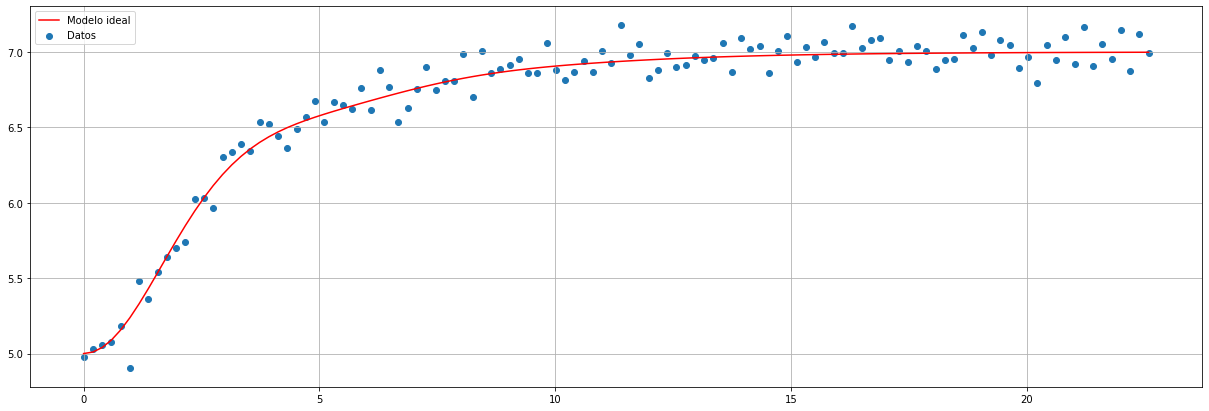

In [6]:
plt.figure(figsize=(21, 7))
plt.scatter(ts, ym, label='Datos')
plt.plot(ts, ys + yinitial, color='red', label='Modelo ideal')
plt.legend(loc='best')
plt.grid(True)

import pandas as pd
import numpy as np
df = pd.DataFrame(np.transpose(np.array([ts,u,ym])),
                  columns=['tiempo',
                           'U',
                           'Y'])
df.to_csv('Datos\DatoEscalon.csv')

## Ajuste de un modelo de primer orden

Se encuentra un modelo de primer orden de la forma:

\begin{equation}
G(s) = \frac{K}{\tau s + 1} \cdot e^{-s\theta}
\end{equation}

Introduciendo además el sesgo.

Librería `tbcontrol.responses`

In [9]:
fopdt

<function tbcontrol.responses.fopdt(t, K, tau, theta=0, y0=0)>

In [10]:
interact(resultplot1, 
         K=(0., 10.), 
         tau=(0., 10.), 
         theta=(0., 10.), 
         y0=(0., 20.));


interactive(children=(FloatSlider(value=5.0, description='K', max=10.0), FloatSlider(value=5.0, description='t…

We can use the `scipy.optimize.curve_fit` tool to do this fit just like when we did regression without time.

In [12]:
[K, tau, theta, y0], _ = scipy.optimize.curve_fit(fopdt, ts, ym, [2.0, 3.2, 0.4, 5.0])
[K, tau, theta, y0]

[2.003851116954733, 2.8683194558942677, 0.4750908906199303, 4.967392477676414]

Estos parámetros definen la función de transferencia de primer orden que mejor se ajusta al comportamiento medido.

In [13]:
Y_1orden = fopdt(ts, K, tau, theta, y0)

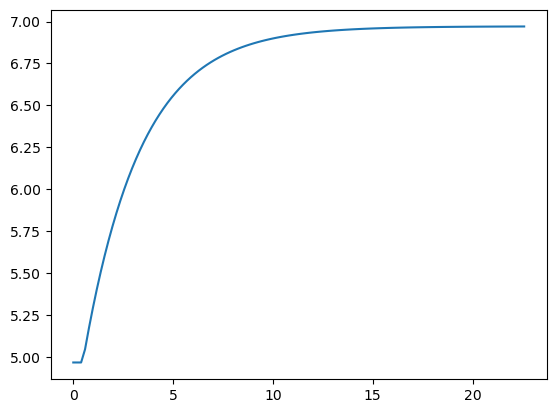

In [14]:
plt.plot(ts,Y_1orden)

\begin{equation}
G(s) = \frac{K}{\tau s + 1} \cdot e^{-s\theta}
\end{equation}
más sesgo.

## Ajuste de un modelo de segundo orden



También puede ajustarse un modelo de segundo orden.

\begin{align}
G(s) &= \frac{K}{(\tau s)^2 + 2\tau \zeta s + 1} \cdot e^{-s\theta} \\
&= \frac{K \omega_0^2}{s^2 + 2\zeta \omega_0 s + \omega_0^2} \cdot e^{-s\theta} \\
\end{align}

Introduciendo además el sesgo.

In [17]:
interact(resultplot2, 
         K=(0., 10.), 
         tau=(0., 10.), 
         theta=(-10., 10.),
         zeta = (-2.0, 2.0),
         y0=(0., 20.));


interactive(children=(FloatSlider(value=5.0, description='K', max=10.0), FloatSlider(value=5.0, description='t…

In [19]:
p2_inicial = [2, 1.2, 1.2, 0.48, 4.97]
[K_2, tau_2, zeta_2, theta_2, y0_2], pcov = scipy.optimize.curve_fit(sopdt, ts, ym, p2_inicial)
[K_2, tau_2, zeta_2, theta_2, y0_2]

[2.0735302747612026,
 1.0558810039658173,
 1.5326870004135313,
 -0.016465117901489315,
 4.897081339498189]

In [13]:
perr = numpy.sqrt(numpy.diag(pcov))
perr

array([0.0717199 , 0.44016312, 0.53483623, 0.33501957, 0.07080369])

In [22]:
Y_2orden = sopdt(ts, K_2, tau_2, zeta_2, theta_2, y0_2)

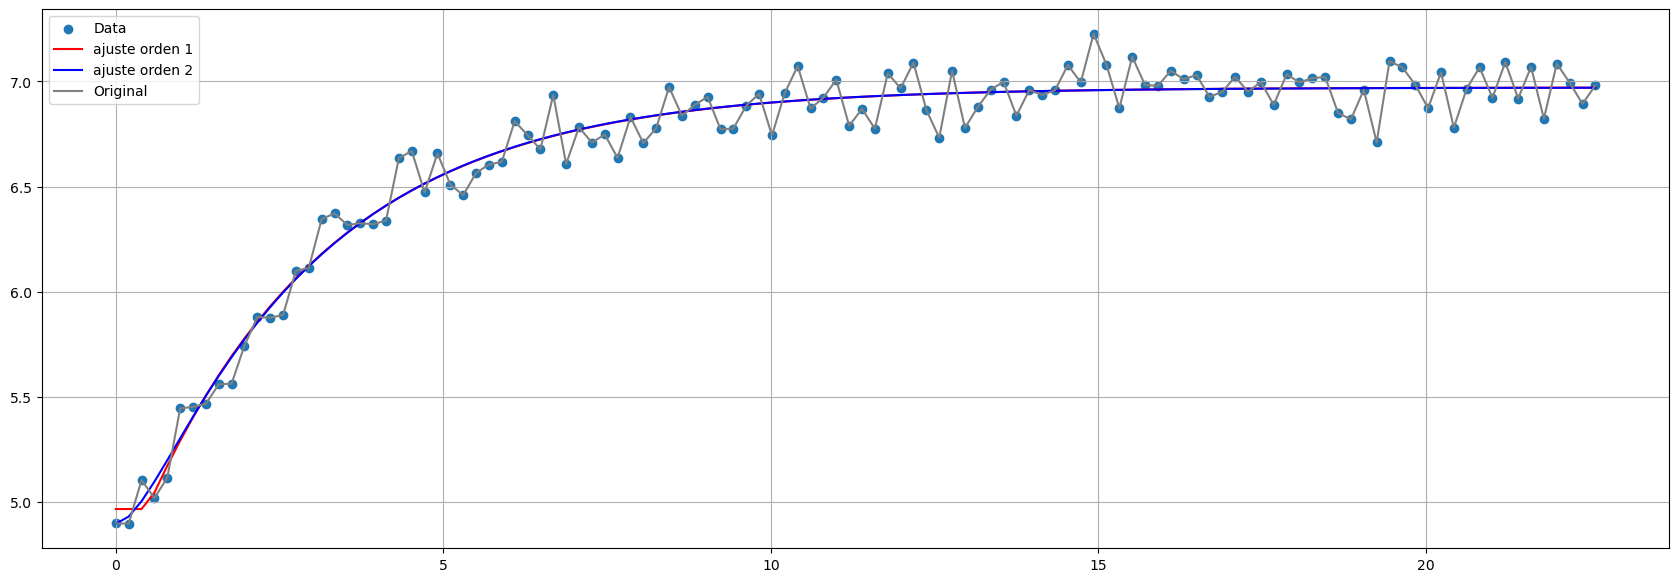

In [24]:
plt.figure(figsize=(21, 7))
plt.scatter(ts, ym, label='Data')
plt.plot(ts, Y_1orden, color='red', label='ajuste orden 1')
plt.plot(ts, Y_2orden, color='blue', label='ajuste orden 2')
plt.plot(ts, ym, color='gray', label='Original')
plt.legend(loc='best')
plt.grid(True)